In [1]:
# required for netCDF file opening
# pip install netCDF4 xarray

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
# Parameters for data import
start_date = "2022-04-01"
end_date   = "2024-12-31"
# Parameters for site location
location = 'Newbury'
lat = 51.400701
lon = -1.2799349

#location = 'Windsor'
#lat = 51.46782
#lon = -0.56927

#location = 'Chinnor'
#lat = 51.72328
#lon = -0.90164

#location = 'Marlborough'
#lat = 51.42145
#lon = -1.71288

In [4]:
# Create empty table for daily rainfall and discharge for a specified date range
# DataFrame with zeros
date_range = pd.date_range(start=start_date, end=end_date, freq="D")
df = pd.DataFrame({"date": date_range, "location": location, "rainfall": 0, "discharge": 0})
df.to_csv('2_Data for EDA.csv', index=False)

In [5]:
## Rainfall data

# Open the NetCDF file with rainfall data
data = xr.open_dataset("rainfall.nc")
# Convert to pandas DataFrame
df_r = data.to_dataframe().reset_index()
# keep one entry per day i.e. rows where bnds = 0 (bounds for start / end of day)
df_r = df_r[df_r['bnds'] == 0]
df_r['time'] = df_r['time'].dt.date
df_r = df_r.drop(['projection_y_coordinate', 'projection_x_coordinate', 'bnds', 'time_bnds', 'transverse_mercator', 'projection_y_coordinate_bnds', 'projection_x_coordinate_bnds'], axis = 1)
df_r['rainfall'] = df_r['rainfall'].fillna(0).round(2)

In [6]:
data_df = data.to_dataframe().reset_index()
data_df

,time,projection_y_coordinate,projection_x_coordinate,bnds,rainfall,transverse_mercator,time_bnds,projection_y_coordinate_bnds,projection_x_coordinate_bnds,latitude,longitude
0,2022-01-01 12:00:00,-87500.0,-187500.0,0,NaN,-2147483647,2022-01-01 09:00:00,-100000.0,-200000.0,48.833482,-10.009903
1,2022-01-01 12:00:00,-87500.0,-187500.0,1,NaN,-2147483647,2022-01-02 09:00:00,-75000.0,-175000.0,48.833482,-10.009903
2,2022-01-01 12:00:00,-87500.0,-162500.0,0,NaN,-2147483647,2022-01-01 09:00:00,-100000.0,-175000.0,48.856586,-9.672318
3,2022-01-01 12:00:00,-87500.0,-162500.0,1,NaN,-2147483647,2022-01-02 09:00:00,-75000.0,-150000.0,48.856586,-9.672318
4,2022-01-01 12:00:00,-87500.0,-137500.0,0,NaN,-2147483647,2022-01-01 09:00:00,-100000.0,-150000.0,48.878707,-9.334313
...,...,...,...,...,...,...,...,...,...,...,...
4445371,2024-12-31 12:00:00,1187500.0,712500.0,1,NaN,-2147483647,2025-01-01 09:00:00,1200000.0,725000.0,60.450324,3.685323
4445372,2024-12-31 12:00:00,1187500.0,737500.0,0,NaN,-2147483647,2024-12-31 09:00:00,1175000.0,725000.0,60.430214,4.137209
4445373,2024-12-31 12:00:00,1187500.0,737500.0,1,NaN,-2147483647,2025-01-01 09:00:00,1200000.0,750000.0,60.430214,4.137209
4445374,2024-12-31 12:00:00,1187500.0,762500.0,0,NaN,-2147483647,2024-12-31 09:00:00,1175000.0,750000.0,60.408577,4.588422


In [7]:
# Filltering for rows for selected locaiton
# Find nearest grid lat / lon
df_r['distance'] = ((df_r["latitude"] - lat)**2 + (df_r["longitude"] - lon)**2)**0.5
df_nearest = df_r.loc[df_r['distance'].idxmin()]
lat_ = df_nearest['latitude']
lon_ = df_nearest['longitude']
# Fillter only rows for selected location
df_r = df_r[(df_r['latitude'] == lat_) & (df_r['longitude'] == lon_)]

# Add to main dataframe
df['rainfall'] = df['date'].map(df_r.set_index('time')['rainfall'])

In [8]:
df.head()

,date,location,rainfall,discharge
0,2022-04-01,Newbury,0.29,0
1,2022-04-02,Newbury,0.12,0
2,2022-04-03,Newbury,4.14,0
3,2022-04-04,Newbury,0.21,0
4,2022-04-05,Newbury,0.88,0


In [9]:
## Discharge data

# Open data file
df_d = pd.read_json('spills.json')
df_d['StartDateTime'] = pd.to_numeric(df_d['StartDateTime'], errors='coerce')
df_d['StopDateTime'] = pd.to_numeric(df_d['StopDateTime'], errors='coerce')
df_d['StartDateTime'] = pd.to_datetime(df_d['StartDateTime'], unit='ms')
df_d['StopDateTime'] = pd.to_datetime(df_d['StopDateTime'], unit='ms')


In [10]:
print(df_d['LocationName'].value_counts().head(10))

LocationName
Windsor                             3017
Chinnor                             2055
Marlborough                         1884
St Stephens Hall (Little London)    1182
Newbury                             1000
South Moreton                        905
Bampton                              793
Farnborough (Warks)                  753
Nightingale Lane CSO                 679
Willingale                           660
Name: count, dtype: int64


In [11]:
df_d

,LocationName,PermitNumber,X,Y,ReceivingWaterCourse,StartDateTime,StopDateTime,Duration,OngoingEvent
0,Theydon Bois,TEMP.2954,547600,197700,Brookhouse Brook,2025-08-01 17:15:00,2025-08-01 18:15:00,60,False
1,Haslemere,CTCR.1203,487790,132530,River Wey,2025-08-01 06:30:00,2025-08-01 07:45:00,75,False
2,Haslemere,CTCR.1203,487790,132530,River Wey,2025-08-01 04:15:00,2025-08-01 04:45:00,30,False
3,Cranleigh,CTCR.1838,504030,139250,Cranleigh Waters,2025-08-01 03:30:00,2025-08-01 06:00:00,150,False
4,Haslemere,CTCR.1203,487790,132530,River Wey,2025-08-01 02:00:00,2025-08-01 03:15:00,75,False
...,...,...,...,...,...,...,...,...,...
59284,"South Ealing Road, W5",TEMP.1929,518000,179000,River Brent,2022-05-11 09:26:00,2022-05-11 09:34:00,8,False
59285,Hampstead Norreys,CNTD.0066,453200,175730,River Pang,2022-04-30 09:15:00,2022-04-30 09:45:00,30,False
59286,Jews Row Wandle Valley Storm Relief CSO,CSAB.0546,525940,175450,River Thames,2022-04-06 13:04:00,2022-04-07 18:18:00,1754,False
59287,Isle of Dogs Pumping Station CSO,CSSC.7688,538400,179700,River Thames,2022-04-01 00:00:00,2022-04-17 21:30:00,24330,False


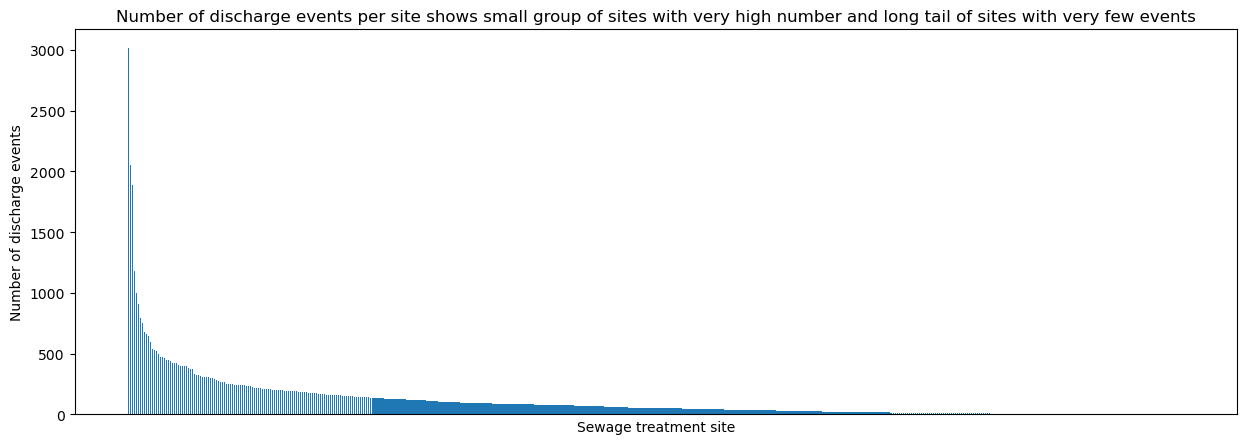

In [12]:
sites = df_d['LocationName'].value_counts()
plt.figure(figsize=(15,5))
plt.bar(sites.index, sites.values)
plt.title('Number of discharge events per site shows small group of sites with very high number and long tail of sites with very few events')
plt.ylabel('Number of discharge events')
plt.xlabel('Sewage treatment site')
plt.xticks([])
plt.show()

In [13]:
# Fillter only rows for selected location
df_d = df_d.loc[df_d['LocationName'] == location]

In [14]:
# Define function for discharge data transfromation
def observations_to_daily_minutes(
    df,
    start_col="StartDateTime",
    end_col="StopDateTime",
    tz=None,
    start_date=None,
    end_date=None,
    day_col_name="date",
):
    """
    Convert row-wise observations (start/end) into daily totals of minutes.

    - df must have start_col and end_col with datetimes
    - Each row is split across days if needed
    - Returns 0–1440 minutes per day
    - Output is limited to [start_date, end_date] if given
    """

    if df.empty:
        return pd.DataFrame(columns=[day_col_name, "minutes"])

    x = df[[start_col, end_col]].copy()
    x[start_col] = pd.to_datetime(x[start_col], errors="coerce")
    x[end_col]   = pd.to_datetime(x[end_col], errors="coerce")
    x = x.dropna(subset=[start_col, end_col]).reset_index(drop=True)

    # Clamp invalid intervals
    x[end_col] = np.where(x[end_col] < x[start_col], x[start_col], x[end_col])
    x[end_col] = pd.to_datetime(x[end_col])

    # Timezone
    if tz is not None:
        for col in (start_col, end_col):
            s = x[col]
            if s.dt.tz is None:
                x[col] = s.dt.tz_localize(tz)
            else:
                x[col] = s.dt.tz_convert(tz)

    # Split by days
    x["start_day"] = x[start_col].dt.normalize()
    x["end_day"]   = x[end_col].dt.normalize()
    x = x.assign(day_list=[
        pd.date_range(sd, ed, freq="D") for sd, ed in zip(x["start_day"], x["end_day"])
    ]).explode("day_list").rename(columns={"day_list": day_col_name})

    # Segment start/end for each day
    day_start = x[day_col_name]
    next_day  = day_start + pd.Timedelta(days=1)
    x["seg_start"] = np.where(x[start_col] > day_start, x[start_col], day_start)
    x["seg_end"]   = np.where(x[end_col]   < next_day,  x[end_col],   next_day)
    x["seg_start"] = pd.to_datetime(x["seg_start"])
    x["seg_end"]   = pd.to_datetime(x["seg_end"])

    # Duration in minutes
    mins = (x["seg_end"] - x["seg_start"]).dt.total_seconds() / 60.0
    x["minutes"] = np.clip(mins, 0, 1440)

    # Aggregate per day
    daily = x.groupby(day_col_name, as_index=False)["minutes"].sum()

    # Build continuous range
    if start_date is None:
        start_date = daily[day_col_name].min()
    else:
        start_date = pd.to_datetime(start_date)
    if end_date is None:
        end_date = daily[day_col_name].max()
    else:
        end_date = pd.to_datetime(end_date)

    full_idx = pd.date_range(start=start_date.normalize(),
                             end=end_date.normalize(), freq="D")
    daily = daily.set_index(day_col_name).reindex(full_idx, fill_value=0).reset_index()
    daily = daily.rename(columns={"index": day_col_name})

    # Clip max 1440
    daily["minutes"] = daily["minutes"].clip(0, 1440)

    # Convert to plain date
    daily[day_col_name] = daily[day_col_name].dt.date

    return daily

In [15]:
daily = observations_to_daily_minutes(
    df_d,
    start_col="StartDateTime",
    end_col="StopDateTime",
    start_date="2022-01-01",
    end_date="2024-12-31"
)

# Add to main dataframe
df['discharge'] = df['date'].map(daily.set_index('date')['minutes'])


In [16]:
df.head()

,date,location,rainfall,discharge
0,2022-04-01,Newbury,0.29,0.0
1,2022-04-02,Newbury,0.12,0.0
2,2022-04-03,Newbury,4.14,0.0
3,2022-04-04,Newbury,0.21,0.0
4,2022-04-05,Newbury,0.88,0.0


In [17]:
# Add columns with rainfall rolling sums for previous days
df['r_d_n-0'] = df['rainfall']
df['r_d_n-1'] = df['rainfall'].rolling(window=2, min_periods=1).sum()
df['r_d_n-2'] = df['rainfall'].rolling(window=3, min_periods=1).sum()
df['r_d_n-3'] = df['rainfall'].rolling(window=4, min_periods=1).sum()
df['r_d_n-4'] = df['rainfall'].rolling(window=5, min_periods=1).sum()
df['r_d_n-5'] = df['rainfall'].rolling(window=6, min_periods=1).sum()
# Add columns with discharge rolling sums for next days days
df['d_d_n+0'] = df['discharge']
df['d_d_n+1'] = df['discharge'] + df['discharge'].shift(-1).fillna(0)
df['d_d_n+2'] = df['discharge'] + df['discharge'].shift(-1).fillna(0) + df['discharge'].shift(-2).fillna(0)
df['d_d_n+3'] = df['discharge'] + df['discharge'].shift(-1).fillna(0) + df['discharge'].shift(-2).fillna(0) + df['discharge'].shift(-3).fillna(0)
df['d_d_n+4'] = df['discharge'] + df['discharge'].shift(-1).fillna(0) + df['discharge'].shift(-2).fillna(0) + df['discharge'].shift(-3).fillna(0) + df['discharge'].shift(-4).fillna(0)
df['d_d_n+5'] = df['discharge'] + df['discharge'].shift(-1).fillna(0) + df['discharge'].shift(-2).fillna(0) + df['discharge'].shift(-3).fillna(0) + df['discharge'].shift(-4).fillna(0) + df['discharge'].shift(-5).fillna(0)

In [18]:
# running counter that resets to 0 on rainy days (rainfall > 25th quantile) and increments otherwise.
rain_day = df['rainfall'] > df['rainfall'].quantile(0.25)
# Create groups that increment at each rain event
groups = rain_day.cumsum()
# Counter = position within each group since the last rain day
df["days_since_rain"] = (~rain_day).groupby(groups).cumsum()

In [19]:
# Add month name and number
df["month"] = df["date"].dt.month
# Add season
def get_season_str(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

def get_season_int(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3

df["season_str"] = df["month"].apply(get_season_str)
df["season_int"] = df["month"].apply(get_season_int)

In [20]:
# add target variable
# 1 = discharge, 0 = no discharge 
def discharge(discharge):
    if discharge > 0:
        return 1
    else:
        return 0

df['target'] = df['discharge'].apply(discharge)

In [21]:
df.head()

,date,location,rainfall,discharge,r_d_n-0,r_d_n-1,r_d_n-2,r_d_n-3,r_d_n-4,r_d_n-5,...,d_d_n+1,d_d_n+2,d_d_n+3,d_d_n+4,d_d_n+5,days_since_rain,month,season_str,season_int,target
0,2022-04-01,Newbury,0.29,0.0,0.29,0.29,0.29,0.29,0.29,0.29,...,0.0,0.0,0.0,0.0,0.0,0,4,Spring,1,0
1,2022-04-02,Newbury,0.12,0.0,0.12,0.41,0.41,0.41,0.41,0.41,...,0.0,0.0,0.0,0.0,0.0,0,4,Spring,1,0
2,2022-04-03,Newbury,4.14,0.0,4.14,4.26,4.55,4.55,4.55,4.55,...,0.0,0.0,0.0,0.0,0.0,0,4,Spring,1,0
3,2022-04-04,Newbury,0.21,0.0,0.21,4.35,4.47,4.76,4.76,4.76,...,0.0,0.0,0.0,0.0,0.0,0,4,Spring,1,0
4,2022-04-05,Newbury,0.88,0.0,0.88,1.09,5.23,5.35,5.64,5.64,...,0.0,0.0,0.0,0.0,0.0,0,4,Spring,1,0


In [22]:
df.describe().round(2)

,date,rainfall,discharge,r_d_n-0,r_d_n-1,r_d_n-2,r_d_n-3,r_d_n-4,r_d_n-5,d_d_n+0,d_d_n+1,d_d_n+2,d_d_n+3,d_d_n+4,d_d_n+5,days_since_rain,month,season_int,target
count,1006,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00,1006.00
mean,2023-08-16 12:00:00,2.43,141.74,2.43,4.85,7.27,9.70,12.12,14.55,141.74,283.48,425.21,566.95,708.69,850.43,0.86,6.93,2.45,0.15
min,2022-04-01 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00
25%,2022-12-08 06:00:00,0.01,0.00,0.01,0.06,0.29,0.62,1.22,2.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,2.00,0.00
50%,2023-08-16 12:00:00,0.20,0.00,0.20,1.23,2.90,4.93,6.94,9.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,2.00,0.00
75%,2024-04-23 18:00:00,2.56,0.00,2.56,6.70,11.35,15.25,19.09,23.13,0.00,0.00,0.00,0.00,0.00,0.00,1.00,10.00,3.00,0.00
max,2024-12-31 00:00:00,38.32,1440.00,38.32,47.73,49.77,63.41,81.87,84.81,1440.00,2880.00,4320.00,5760.00,7200.00,8640.00,14.00,12.00,4.00,1.00
std,NaN,4.79,377.52,4.79,7.48,9.68,11.75,13.59,15.30,377.52,723.49,1052.19,1367.23,1667.90,1956.03,1.98,3.30,1.08,0.36


In [23]:
# save file as CSV
df.to_csv('2_Data for EDA.csv', index=False)